This is a notebook which is a supplement to my blogpost about VQE.

It's not a VQE tutorial, rather an illustration and invitation for the Reader to explore the concept described in the blogpost on their own.

In [8]:
from pyquil.api import WavefunctionSimulator
from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.api import WavefunctionSimulator
import numpy as np

# Helper methods

Some people might find these two confusing, so here's additional explanation:
`circuit_expectation_value` produces a value between 0 and 1. It simulates running given quantum program infinite number of times and averaging all the 0s and 1s we got in process. 
`Z_expectation_value` on the other hand gives us the expectation value of Z operator given a quantum state, so <psi|Z|psi>.

Consider the following:
We have a circuit which produces the following state: `|psi> = sqrt(0.3)|0> + sqrt(0.7)|1>`.
If we measure it infinite number of times, we will get "0" 30% of times and "1" 70% of times. So the expected value of such circuit is 0.7.

However, if we wan't to measure the expectation value of `Z` operator, we need to take into the account, that state |0> is associated with the eigenvalue 1 and state |1> with the eigenvalue -1. This means, that for each <psi|Z|psi> = 0.3 * 1 + 0.7 * (-1) = -0.4

So each "0" we measure, we substitute it by "1" and each "1" we measure, we substitute it by "-1". And to get the expectation value, we simply average all the "1"s and "-1"s.

It turns out that a simple transformation: X -> (-X+0.5)*2 maps the values from [0, 1] to [-1, 1].

In [32]:
# This calculates what's the expectation value of the quantum state produced by given program.
def circuit_expectation_value(program):
    wf_sim = WavefunctionSimulator()
    result = 0 
    wavefunction = wf_sim.wavefunction(program)
    prob_dict = wavefunction.get_outcome_probs()
    for key, value in prob_dict.items():
        result += value * int(key)
    return result

# This calculates what's the expectation value of the <psi|Z|psi>, where |psi> is given the state produced by given program.
def Z_expectation_value(program):
    circuit_result = circuit_expectation_value(program)
    return (-circuit_result+0.5)*2

# VQE example

Our Hamiltonian is:

H = 2\*Z + X + I

So the individual terms are:
- H_1 = 2*Z
- H_2 = X
- H_3 = I

In [21]:
# Arbitrary value of theta
theta = 1.5 * np.pi
# Some ansatz
ansatz = RY(theta, 0)
# Circuit for measuring the first term
# It consists only of Z, which is already in the computational basis
circuit_1 = Program(ansatz)
# Circuit for measuring the second term
# It corresponds to X, so we need additional RY rotation. 
circuit_2 = Program([ansatz, RY(np.pi/2, 0)])

In [22]:
#Here we account for the constants
term_1_value = 2 * Z_expectation_value(circuit_1)
print("TERM 1:", term_1_value)
term_2_value = Z_expectation_value(circuit_2)
print("TERM 2:", term_2_value)
term_3_value = 1
print("TERM 3:", term_3_value)

TERM 1: -4.440892098500626e-16
TERM 2: 1.0
TERM 3: 1


In [23]:
energy_estimate = term_1_value + term_2_value + term_3_value
print("Energy estimate:", energy_estimate)

Energy estimate: 1.9999999999999996


In [24]:
energy_estimates = []
term_1_list = []
term_2_list = []
term_3_list = []

theta_values = np.linspace(0, 2*np.pi, 100)

for theta in theta_values:
    ansatz = Program([RY(theta, 0)])
    circuit_1 = ansatz
    circuit_2 = ansatz + Program(RY(np.pi/2, 0))
    term_1_value = 2 * Z_expectation_value(circuit_1)
    term_2_value = Z_expectation_value(circuit_2)
    term_3_value = 1
    energy_estimate = term_1_value + term_2_value + term_3_value
    term_1_list.append(term_1_value)
    term_2_list.append(term_2_value)
    term_3_list.append(term_3_value)
    energy_estimates.append(energy_estimate)
    

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [26]:
def plot_values(x, y, title=None):
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(tck.FuncFormatter(
           lambda val,pos: '{:.2f}$\pi$'.format(val/np.pi) if val !=0 else '0'
        ))
    ax.xaxis.set_major_locator(tck.MultipleLocator(base=np.pi/4))
    ax.plot(x, y)
    if title is not None:
        ax.set_title(title)

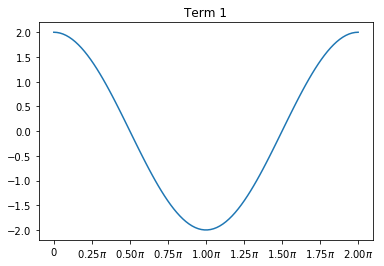

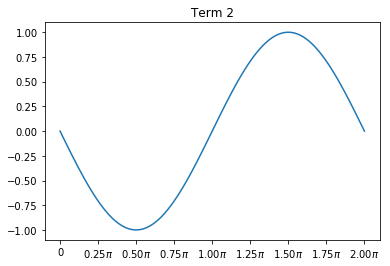

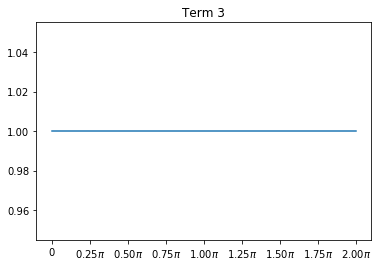

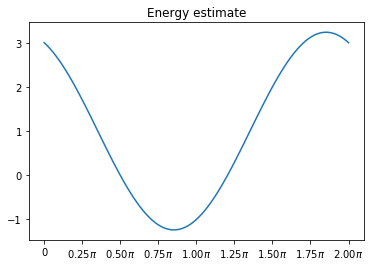

In [27]:
plot_values(theta_values, term_1_list, "Term 1")
plot_values(theta_values, term_2_list, "Term 2")
plot_values(theta_values, term_3_list, "Term 3")
plot_values(theta_values, energy_estimates, "Energy estimate")